# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy házi feladataként készült. 
<br>
A notebook kiindulási alapja a tantárgy segédanyaga, a tantárgy oktatóinak tulajdona: https://github.com/BME-SmartLab-Education/vitmav45/blob/master/02/02-01-XOR-Numpy-compiled.ipynb

</PRE>
## Neptun kód: C44ZM7

# XOR feladat neuron hálós megközelítése

Először a historikusan is nagy jelentőségű XOR problémát (aminek közvetve köszönhetjük a backpropagation algoritmust) fogjuk megoldani "pure" Python-ban. 

A XOR probléma a gépi tanulás szempontjából azért érdekes, mert míg az AND és az OR logikai függvények architektúrális szempontból megoldhatóak egyetlen neuron segítségével, addig a XOR-ra ez nem teljesül. Az AND és az OR esetében létezik a függvény által felveheto kimeneti értékek között egy olyan hipersík (szeparálósík), amely segítségével egyértelmű a szeparáció.

A XOR probléma további tárgyalásához tekintsük az alábbi igazságtáblát:


  A     | B   | A XOR B
  :----:| :----:|:--------:
  0     | 0   |    0
  1     | 0   |    1
  0     | 1   |    1
  1     | 1   |    0

Populating the interactive namespace from numpy and matplotlib


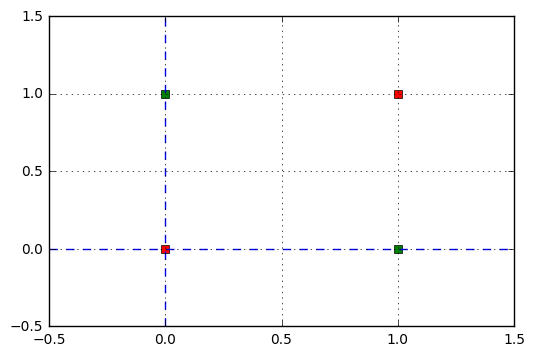

In [1]:
# Pylab grafikus megjelenítocsomag meghívása (a % jel a notebook miatt szükséges)
%pylab inline

# "Igaz" logikai értékek megadása
true_x = [1, 0]
true_y = [0, 1]

# "Hamis" logikai értékek megadása
false_x = [0, 1]
false_y = [0, 1]

# Jelöljük pirossal a hamis logikai értékeket, zölddel pedig az igazakat.
plot1 = plt.plot(true_x, true_y,'gs')
plot2 = plt.plot(false_x, false_y, 'rs')

# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
# Négyzetrács megjelenítése
plt.grid(True)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
# Az ábra kirajzolása
plt.show()

Mint ahogy a fenti ábrán is látszódik, nem tudjuk egyetlen szeparáló síkkal (2 dimenzióban egyenessel) külön választani az igaz és a hamis értékeket.

Mivel egyetlen síkkal nem tudjuk szétválasztani a kimeneteket ezért a neurális hálózat be- és kimeneti rétege közé szükségszerű, hogy további, un. rejtett réteg(ek)et illesszünk be. 

Mielőtt a konkrét programkóddal ismerkednénk meg, tekintsük át egy mesterséges neurális hálózat általános architektúráját, felépítését. Ahhoz, hogy neurális hálózatunk felügyelt tanítás során rendeltetésszerűen működjön, szükségünk van:

 - Tanító adatokra (bemenet és felügyelt esetben kimenet),
 - Magára a neurális hálózatra, amely magában foglal:
   - bemeneti réteget, egy kimeneti réteget, illetve köztük elhelyezkedo rejtett réteg(ek)et,
   - rétegenként tetszőleges számú neuronokat, 
   - a rétegeket összekötő, különböző súlyokkal rendelkező éleket,
   - a neuronokon elvégzett lineáris (súlyozott összegzés), illetve nem lineáris függvényeket (pl. sigmoid, tanh, ReLU, stb.).
 - Tanítási fázist:
   - a bemenő adatokat "végigküldjük" a hálózaton (forward propagation),
   - a bemenő adatok alapján kiszámoljuk a hálózat által "jósolt" eredményt,
   - a jósolt eredmény és a tanító adatokban szereplő elvárt eredmény közötti kapcsolat kiszámítása (költségfüggvény),
   - a kapott hibaérték visszaterjesztése (backpropagation) a hálózaton, a láncszabály és a parciális deriválás módszerével (gradiensek kiszámítása)
   - a rétegek közötti súlyok frissítését a gradiensek segítségével.
   
Első lépésként importáljuk a már jól ismert Numpy csomagot, amire np-ként fogunk hivatkozni:

In [2]:
import numpy as np

Töltsük be a matplotlib grafikus megjelenítőt:

In [3]:
%matplotlib inline

Az aktivációs függvény definiálása. A "forward" lépésben a hálózatot alkotó neuronokkal két műveletet hajtunk végre: (1) Egy súlyozott lineáris összegzést, (2) illetve egy nemlineáris aktiválási függvényt. A lineáris függvény nem csinál mást, minthogy összegzi az adott neuronhoz beérkező értékeket a hozzá vezető súly értékével megszorozva. Ezután a kapott eredményen alkalmazzuk a nemlineáris aktivációs függvényt. Ez általában annyit csinál, hogy amennyiben az argomentuma (a korábbi szummázás)meghalad egy bizonyos küszöbértéket, akkor a neuron továbbítja a következő rétegre az adatokat. Itt a sigmoid-ot használjuk erre a célra, amit előbb definiálunk majd megnézzük, hogy hogyan néz ki:

In [4]:
def activation(x):
    return 1 / (1 + np.exp(-x))

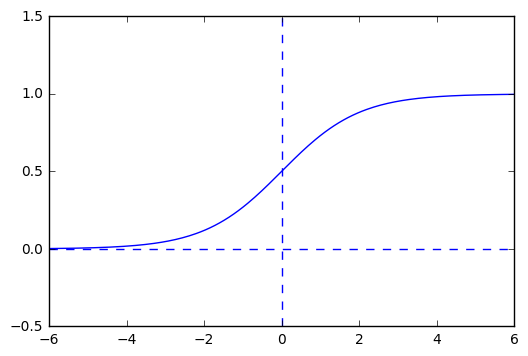

In [5]:
segedX=np.linspace(-6,6,200)
# A jobb ábrázálhatóság miatt, szélesebb tartományokat jelenítünk meg
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
# Az x és y tengely megjelenítése
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.plot(segedX,activation(segedX))

Következőnek definiáljuk az aktivációs függvény deriváltját. A tanítási fázis során, a hiba végigterjesztésekor (backpropagation) az aktivációs függvényt, azaz annak a deriváltját használjuk. Definiáljuk majd nézzük meg ezt is, hogy hogyan néz ki sigmoid esetén:

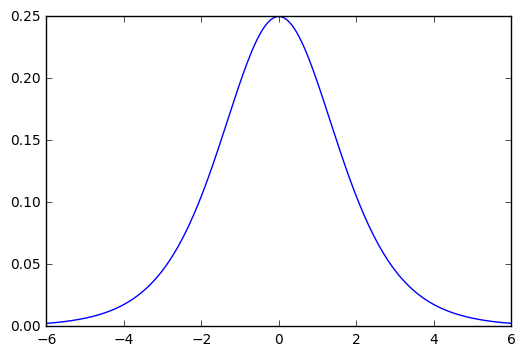

In [6]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
plt.plot(segedX,dactivation(segedX))

Most jön a java! Definiáljuk az MLP osztályt négy függvénnyel: inicializálás, súlyok resetelése, forward lépés, backward lépés.

In [7]:
# MLP osztály létrehozása.
class MLP:
    
    # A hálózat inicializálása az argumentumként megadott méretek alapján.
    def __init__(self, *args):
        # random seed megadása
        np.random.seed(123)
        # A hálózat formája (rétegek száma), amely megegyezik a paraméterek számával
        self.shape = args
        n = len(args)
        # Rétegek létrehozása
        self.layers = []
        # Bemeneti réteg létrehozása (+1 egység a BIAS-nak)
        self.layers.append(np.ones(self.shape[0]+1))
        # Rejtett réteg(ek) és a kimeneti réteg létrehozása
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Súlymátrix létrehozása
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw fogja tartalmazni a súlyok utolsó módosításait (a momentum módszer számára)
        self.dw = [0,]*len(self.weights)
        # HF2 start dropout 
        #(kimeneti réteget nem dobjuk el)
        self.dropouts = self.layers
        self.update_dropouts()
        # HF2 end dropout
        # Súlyok újrainicializálása
        self.reset()
        
    #HF2 start dropout
    def update_dropouts(self, dropout_param = 0):
        n  = np.size(self.dropouts)
        for i in range(n):
            self.dropouts[i]=np.random.random(self.dropouts[i].size)
            self.dropouts[i]-=dropout_param
            self.dropouts[i] = np.abs(np.ceil(self.dropouts[i]))
            
        self.dropouts[n-1]=np.ones(np.size(self.dropouts[n-1]))
    #HF2 end dropout
    
    # Súlyok újrainicializálási függvényének definiálása
    def reset(self):
        for i in range(len(self.weights)):
            # véletlen számok [0,1) tartományban 
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # átskálázzuk a súlyokat -1..1 tartományba
            self.weights[i][...] = (2*Z-1)*1

    # A bemenő adatok végigküldése a hálózaton, kimeneti rétegig (forward propagation)
    def propagate_forward(self, data):
        # Bemeneti réteg beállítása (tanító adatok)
        self.layers[0][0:-1] = data
        # Az adatok végigküldése a bemeneti rétegtől az utolsó előtti rétegig (az utolsó ugyanis a kimeneti réteg).
        # A szigmoid aktivációs függvény használatával, mátrixszorzások alkalmazásával.
        # Az előadáson a "layers" változót jelöltük "a"-val.
        for i in range(1,len(self.shape)):
            #HF2 start dropout
            #Szelektálás a dropout tábla alapján
            layers_remains = np.multiply(self.layers[i-1],self.dropouts[i-1])
            self.layers[i][...] = activation(np.dot(layers_remains,self.weights[i-1]))
            #HF2 end dropout
        # Visszatérés a hálózat által becsült eredménnyel
        return self.layers[-1]

    # Hibavisszaterjesztés (backpropagation) definiálása. 
    # A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
    # mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló 
    # "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
    # akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy lokális 
    # minimumban és sose éri el azt.
    # Jelen implementációban a momentum is megvalósításra kerül, mely figyelembe veszi az előző
    # epoch-ban számolt gradienst is. Ez egy fajta regularizációként működik, segíti a tanítást. 
    def propagate_backward(self, target, lrate=0.1, momentum=0.1, l1_param=0.0, l2_param=0.0):
        deltas = []
        # Hiba kiszámítása a kimeneti rétegen
        error = -(target-self.layers[-1]) # y-y_kalap
        # HF2 start l2reg
        # Hiba paraméter L1,L2-vel: C=C_0+l1*sum(|w|)+1/2*l2*sum(w^2)
        #Súlyok összegzése:
        sumWL1 = 0.0
        sumWL2 = 0.0
        
        for i in range(len(self.weights)):
            sumWL1+=np.sum(np.abs(self.weights[i]))
            sumWL2+=np.sum(np.square(self.weights[i]))            
        error = error +l1_param*sumWL1
        error = error +1/2*l2_param*sumWL2
       
        # HF2 end l2reg
        # error*dactivation(s(3))
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            #HF2 start dropout
            #Szelektálás a dropout tábla alapján
            layers_remains = np.multiply(self.layers[i-1],self.dropouts[i-1])
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(layers_remains,self.weights[i-1]))
            #HF2 end dropout
            deltas.insert(0,delta)            
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
            dw = -lrate*np.dot(layer.T,delta) + momentum*self.dw[i]
            
            #HF2 start l2reg
            #dw=alapdw+momentum+l1+l2
            dw += -lrate*l1_param*np.sign(self.weights[i])-lrate*l2_param*self.weights[i]
            #HF2 end l2reg
            
            # súlyok módosítása
            self.weights[i] += dw 
            '''
            # "hibás", de működő kód
            dw = np.dot(layer.T,delta)
            self.weights[i] -= lrate*dw - momentum*self.dw[i]  
            '''
            # a súlymódosítás eltárolása
            self.dw[i] = dw

        # Visszatérés a hibával
        return (error**2).sum()

In [8]:
def learn(network,samples, errlog=None, epochs=20000, lrate=1, momentum=0.4, batch_size=3, l1_param=0.00001, l2_param=0.00001, dropout_param = 0.0, inform = True):
        # Tanítási fázis, epoch-szor megyünk át a mini-batch-en.
        # HF2 start minibatch
        # Ne legyen túl nagy a batchSize!
        if (batch_size>samples.size):
            raise IndexError("Too big batchSize!")
        #HF2 end minibatch    
        for i in range(epochs):
            if((i+1)%500)==0 and inform:
                print(i+1,". epoch: ")
            # HF2 start dropout
            #Epochonként új részháló
            network.update_dropouts(dropout_param)
            if((i+1)%500)==0 and dropout_param>0 and inform:
                print(network.dropouts)
            # HF2 end dropout
            
            # HF2 start minibatch
            # Mini-batch gradient descent
            # A minta egy-egy részével tanulunk
            # Összekerverjük és az elejét nézzük
            shuffle = samples.copy()
            np.random.shuffle(shuffle)
            err = 0
            #vesszük a mini-batch-t
            for k in range(0,batch_size):
                network.propagate_forward( shuffle['input'][k])
                err += network.propagate_backward( shuffle['output'][k], lrate, momentum ,l1_param, l2_param)
            err = err/batch_size
            if((i+1)%500)==0 and inform:
                print("error: ", err)
            if errlog is not None:
                errlog.append(err)
        # HF2 end minibatch
            
        # Tesztelési fázis - Ez a neurális háló ugyanazt az adathalmazt használja mind a tanításra, mind a
        # tesztelésre. Itt még nincs külön tanító, validációs és teszt halmaz. A művelet ebben a fázisában
        # egyszerűen csak végigküldjük a négy lehetséges esetet, ami a XOR problémában elofordul.
        
        # Létrehozunk egy üres tömböt a háló által becsült értékekek ("o" mint output)
        o = np.zeros(4)
        
        # Feltöltjük a tömböt a háló által becsült értékekkel és szövegesen is kiíratjuk az eredményt
        for i in range(samples.size):
            o[i] = (network.propagate_forward( samples['input'][i]))
            print (i, samples['input'][i], '%.2f' % o[i], ' (elvárt eredmény %d)' % samples['output'][i])
        if inform:          
            # Megjelenítés
            plt.figure(figsize=(10, 5))
            plt.title('XOR logikai kapu')

            # Eredeti értékek megjelenítése:

            # Igaz pontok elhelyezkedése
            true_x = [1, 0]
            true_y = [0, 1]
            # Hamis pontok elhelyezkedése
            false_x = [0, 1]
            false_y = [0, 1]
            # Jelöljük pirossal a hamis logikai értékeket, zölddel pedig az igazakat.
            plot1 = plt.plot(true_x, true_y,'gs', label = 'Eredeti igaz értékek')
            plot2 = plt.plot(false_x, false_y, 'rs', label = 'Eredeti Hamis értékek')

            # Háló által becsült értékek megjelenítése:

            # Igaz pontok elhelyezkedése
            true_x = [1, 0]
            true_y = [o[0], o[2]]
            # Hamis pontok elhelyezkedése
            false_x = [0, 1]
            false_y = [o[3], o[1]]
            plot3 = plt.plot(true_x, true_y, 'bs', lw = 2, label = 'Becsült igaz értékek')
            plot4 = plt.plot(false_x, false_y, 'ys', lw = 2, label = 'Becsült hamis értékek')
            plt.legend(loc='upper right')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.xlim(-1, 2)
            plt.ylim(-1, 2)
            plt.grid(True)
            plt.show()

In [9]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

In [10]:
# Tanító minta táblázatának létrehozása
samples = np.zeros(4, dtype=[('input',  float, 2), ('output', float, 1)])

500 . epoch: 
error:  0.00496209735583
1000 . epoch: 
error:  0.00183042758755
1500 . epoch: 
error:  0.00268178901529
2000 . epoch: 
error:  0.00213398539092
2500 . epoch: 
error:  0.00182211449298
3000 . epoch: 
error:  0.000833552024077
3500 . epoch: 
error:  0.00155419974819
4000 . epoch: 
error:  0.00155780023808
4500 . epoch: 
error:  0.000868542273487
5000 . epoch: 
error:  0.000700214034179
5500 . epoch: 
error:  0.000808117944652
6000 . epoch: 
error:  0.00131737011653
6500 . epoch: 
error:  0.000696267487039
7000 . epoch: 
error:  0.00132320570992
7500 . epoch: 
error:  0.00128085935201
8000 . epoch: 
error:  0.00128838187663
8500 . epoch: 
error:  0.000681163298226
9000 . epoch: 
error:  0.00123408957174
9500 . epoch: 
error:  0.000707556468461
10000 . epoch: 
error:  0.000703257083339
10500 . epoch: 
error:  0.00116404674662
11000 . epoch: 
error:  0.00123274674266
11500 . epoch: 
error:  0.00116846384736
12000 . epoch: 
error:  0.000686249298791
12500 . epoch: 
error:  0.0

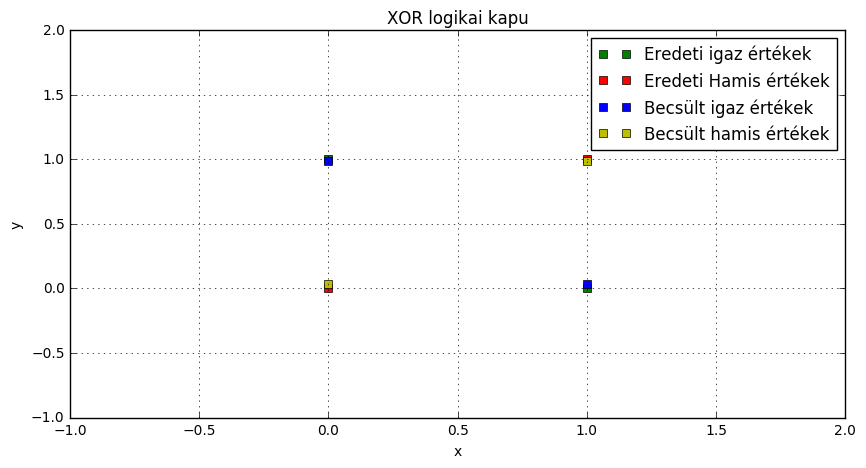

In [11]:
network.reset()

# Tanító adatok megadása a rendszernek
samples[0] = (0,0), 0
samples[1] = (1,0), 1
samples[2] = (0,1), 1
samples[3] = (1,1), 0

# Tanítás/Tesztelés indítása
learn(network, samples)

0 [ 0.  0.] 0.02  (elvárt eredmény 0)
1 [ 1.  0.] 0.97  (elvárt eredmény 1)
2 [ 0.  1.] 0.98  (elvárt eredmény 1)
3 [ 1.  1.] 0.05  (elvárt eredmény 0)
0 [ 0.  0.] 0.01  (elvárt eredmény 0)
1 [ 1.  0.] 0.98  (elvárt eredmény 1)
2 [ 0.  1.] 0.97  (elvárt eredmény 1)
3 [ 1.  1.] 0.02  (elvárt eredmény 0)
0 [ 0.  0.] 0.01  (elvárt eredmény 0)
1 [ 1.  0.] 0.96  (elvárt eredmény 1)
2 [ 0.  1.] 0.95  (elvárt eredmény 1)
3 [ 1.  1.] 0.01  (elvárt eredmény 0)


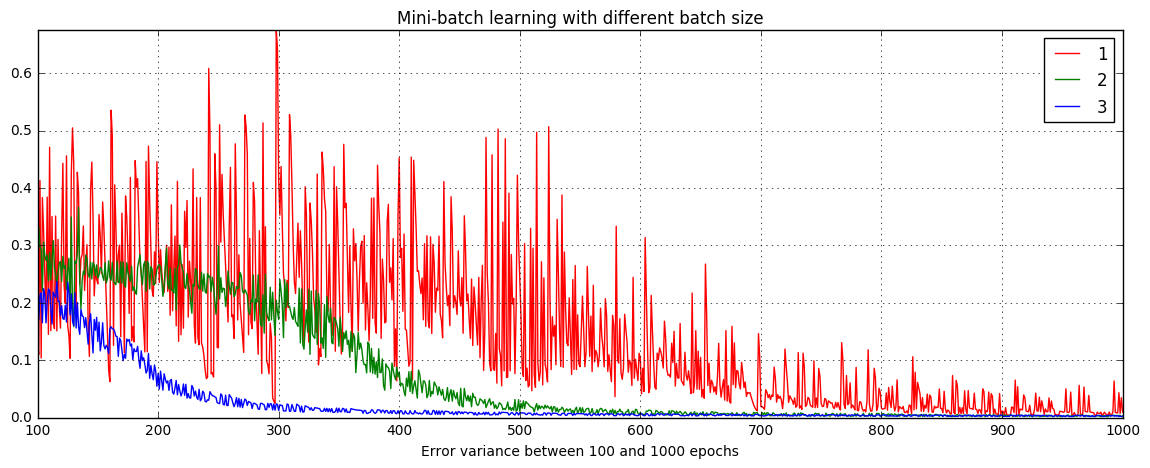

In [15]:
errlog1 = []
errlog2 = []
errlog3 = []
network.reset()
learn(network, samples, errlog1, 5000,1,0.4,1,0.00001,0.00001,0.0,False)
network.reset()
learn(network, samples, errlog2, 5000,1,0.4,2,0.00001,0.00001,0.0,False)
network.reset()
learn(network, samples, errlog3, 5000,1,0.4,3,0.00001,0.00001,0.0,False)

plt.figure(figsize=(14, 5))
plt.plot(errlog1,'r',label = '1')
plt.plot(errlog2,'g',label = '2')
plt.plot(errlog3,'b',label = '3')
min_epoch=100
max_epoch=1000
max_y=max(np.max(errlog1[min_epoch:max_epoch]),np.max(errlog2[min_epoch:max_epoch]),np.max(errlog3[min_epoch:max_epoch]))
plt.axis([min_epoch,max_epoch, 0, max_y])
plt.xlabel("Error variance between "+str(min_epoch)+" and "+str(max_epoch)+" epochs")
plt.title('Mini-batch learning with different batch size')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

0 [ 0.  0.] 0.01  (elvárt eredmény 0)
1 [ 1.  0.] 0.97  (elvárt eredmény 1)
2 [ 0.  1.] 0.99  (elvárt eredmény 1)
3 [ 1.  1.] 0.02  (elvárt eredmény 0)
0 [ 0.  0.] 0.12  (elvárt eredmény 0)
1 [ 1.  0.] 0.97  (elvárt eredmény 1)
2 [ 0.  1.] 0.98  (elvárt eredmény 1)
3 [ 1.  1.] 0.03  (elvárt eredmény 0)
0 [ 0.  0.] 0.02  (elvárt eredmény 0)
1 [ 1.  0.] 0.98  (elvárt eredmény 1)
2 [ 0.  1.] 0.98  (elvárt eredmény 1)
3 [ 1.  1.] 0.09  (elvárt eredmény 0)


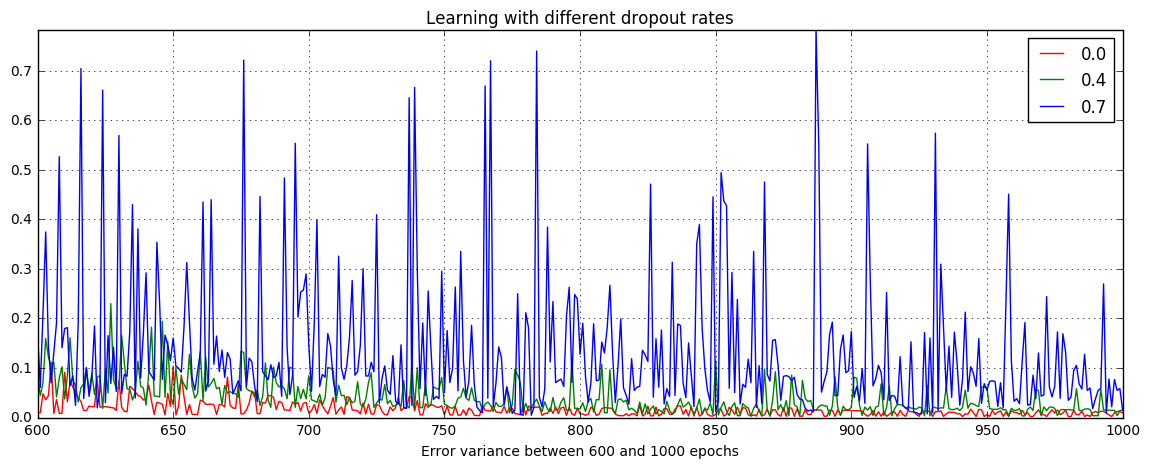

In [14]:
errlog1 = []
errlog2 = []
errlog3 = []
network.reset()
learn(network, samples, errlog1, 5000,0.6,0.7,1,0.0,0.0,0.0,False)
network.reset()
learn(network, samples, errlog2, 5000,0.6,0.7,1,0.0,0.0,0.4,False)
network.reset()
learn(network, samples, errlog3, 5000,0.6,0.7,1,0.0,0.0,0.7,False)

plt.figure(figsize=(14, 5))
plt.plot(errlog1,'r',label = '0.0')
plt.plot(errlog2,'g',label = '0.4')
plt.plot(errlog3,'b',label = '0.7')
min_epoch=600
max_epoch=1000
max_y=max(np.max(errlog1[min_epoch:max_epoch]),np.max(errlog2[min_epoch:max_epoch]),np.max(errlog3[min_epoch:max_epoch]))
plt.axis([min_epoch,max_epoch, 0, max_y])
plt.xlabel("Error variance between "+str(min_epoch)+" and "+str(max_epoch)+" epochs")
plt.title('Learning with different dropout rates')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

0 [ 0.  0.] 0.01  (elvárt eredmény 0)
1 [ 1.  0.] 0.98  (elvárt eredmény 1)
2 [ 0.  1.] 0.99  (elvárt eredmény 1)
3 [ 1.  1.] 0.02  (elvárt eredmény 0)
0 [ 0.  0.] 0.01  (elvárt eredmény 0)
1 [ 1.  0.] 0.96  (elvárt eredmény 1)
2 [ 0.  1.] 0.96  (elvárt eredmény 1)
3 [ 1.  1.] 0.03  (elvárt eredmény 0)
0 [ 0.  0.] 0.06  (elvárt eredmény 0)
1 [ 1.  0.] 0.99  (elvárt eredmény 1)
2 [ 0.  1.] 0.99  (elvárt eredmény 1)
3 [ 1.  1.] 0.04  (elvárt eredmény 0)


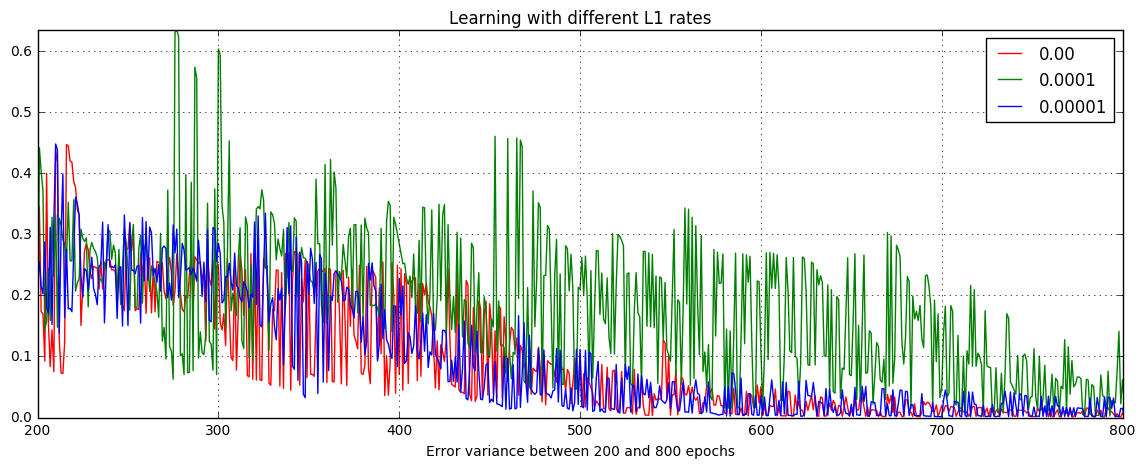

In [47]:
errlog1 = []
errlog2 = []
errlog3 = []
network.reset()
learn(network, samples, errlog1, 5000,0.6,0.8,1,0.00,0.0,0.0,False)
network.reset()
learn(network, samples, errlog2, 5000,0.6,0.8,1,0.0001,0.0,0.0,False)
network.reset()
learn(network, samples, errlog3, 5000,0.6,0.8,1,0.00001,0.0,0.0,False)

plt.figure(figsize=(14, 5))
plt.plot(errlog1,'r',label = '0.00')
plt.plot(errlog2,'g',label = '0.0001')
plt.plot(errlog3,'b',label = '0.00001')
min_epoch=200
max_epoch=800
max_y=max(np.max(errlog1[min_epoch:max_epoch]),np.max(errlog2[min_epoch:max_epoch]),np.max(errlog3[min_epoch:max_epoch]))
plt.axis([min_epoch,max_epoch, 0, max_y])
plt.xlabel("Error variance between "+str(min_epoch)+" and "+str(max_epoch)+" epochs")
plt.title('Learning with different L1 rates')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

0 [ 0.  0.] 0.01  (elvárt eredmény 0)
1 [ 1.  0.] 0.99  (elvárt eredmény 1)
2 [ 0.  1.] 0.98  (elvárt eredmény 1)
3 [ 1.  1.] 0.02  (elvárt eredmény 0)
0 [ 0.  0.] 0.07  (elvárt eredmény 0)
1 [ 1.  0.] 0.95  (elvárt eredmény 1)
2 [ 0.  1.] 0.95  (elvárt eredmény 1)
3 [ 1.  1.] 0.09  (elvárt eredmény 0)
0 [ 0.  0.] 0.02  (elvárt eredmény 0)
1 [ 1.  0.] 0.98  (elvárt eredmény 1)
2 [ 0.  1.] 0.98  (elvárt eredmény 1)
3 [ 1.  1.] 0.03  (elvárt eredmény 0)


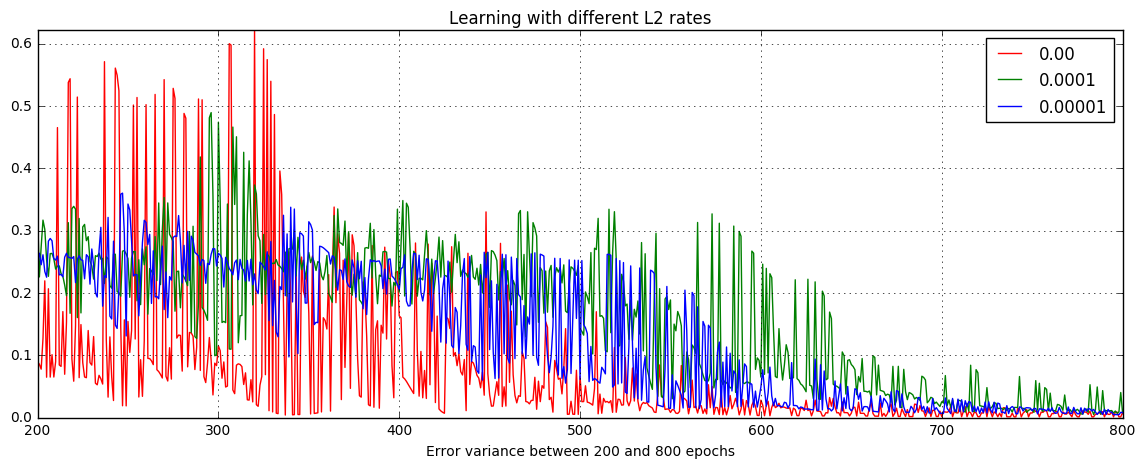

In [49]:
errlog1 = []
errlog2 = []
errlog3 = []
network.reset()
learn(network, samples, errlog1, 5000,0.6,0.8,1,0.0,0.00,0.0,False)
network.reset()
learn(network, samples, errlog2, 5000,0.6,0.8,1,0.0,0.0001,0.0,False)
network.reset()
learn(network, samples, errlog3, 5000,0.6,0.8,1,0.0,0.00001,0.0,False)

plt.figure(figsize=(14, 5))
plt.plot(errlog1,'r',label = '0.00')
plt.plot(errlog2,'g',label = '0.0001')
plt.plot(errlog3,'b',label = '0.00001')
min_epoch=200
max_epoch=800
max_y=max(np.max(errlog1[min_epoch:max_epoch]),np.max(errlog2[min_epoch:max_epoch]),np.max(errlog3[min_epoch:max_epoch]))
plt.axis([min_epoch,max_epoch, 0, max_y])
plt.xlabel("Error variance between "+str(min_epoch)+" and "+str(max_epoch)+" epochs")
plt.title('Learning with different L2 rates')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()